In [1]:
# Install required packages.

!pip install torch-geometric
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 12.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=3dafce87f24b32acbcd380179b32a5d200cbc94b670c1cdd9a3acbaabfe72c29
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=d1c2a22830e825d7e686d4b0242344817be2cb478dee2d08d647149c69a29f31
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [2]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.datasets import MovieLens
from torch_geometric.nn import GCNConv, SAGEConv, to_hetero, GATConv, GATv2Conv
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import numpy as np

In [3]:
dataset_path = '/tmp/'
dataset = MovieLens(root=dataset_path)

Extracting /tmp/raw/ml-latest-small.zip
Processing...


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Batches:   0%|          | 0/305 [00:00<?, ?it/s]

Done!


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = dataset[0].to(device)

# Add user node features for message passing:
data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes

# Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
data = T.ToUndirected()(data)
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)


weight = torch.bincount(train_data['user', 'movie'].edge_label)
weight = weight.max() / weight


def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()


class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

stats = dict(train_rmse=[], val_rmse=[], test_rmse=[], loss=[])

with tqdm.trange(1, 301) as pbar:
    for epoch in pbar:
        loss = train(model, optimizer)
        stats['train_rmse'].append(test(model, train_data))
        stats['val_rmse'].append(test(model, val_data))
        stats['test_rmse'].append(test(model, test_data))
        stats['loss'].append(loss)
        pbar.set_postfix(dict(epoch=epoch, loss=loss))

  0%|          | 0/300 [00:00<?, ?it/s]

ФИО: Мушенко Егор Сергеевич

## Задание

1) Подберите оптимальные параметры для сети из примера выше(2 балла)

2) Попробуйте вместо GraphSage модуль Graph Attention и также подберите оптимальные параметры  (2 балла)


In [5]:
class MyGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
        self.conv2 = GATConv((-1, -1), out_channels, add_self_loops=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [6]:
class MyModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.encoder = MyGNNEncoder(hidden_channels, out_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(out_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [7]:
model = MyModel(60, 5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
MyStats = dict(train_rmse=[], val_rmse=[], test_rmse=[], loss=[])

with tqdm.trange(300) as pbar:
    for epoch in pbar:
        loss = train(model, optimizer)
        MyStats['train_rmse'].append(test(model, train_data))
        MyStats['val_rmse'].append(test(model, val_data))
        MyStats['test_rmse'].append(test(model, test_data))
        MyStats['loss'].append(loss)
        pbar.set_postfix(dict(epoch=epoch+1, loss=loss))

  0%|          | 0/300 [00:00<?, ?it/s]

In [9]:
class MyAnotherGNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATv2Conv((-1, -1), hidden_channels, add_self_loops=False)
        self.conv2 = GATv2Conv((-1, -1), out_channels, add_self_loops=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [10]:
class MyAnotherModel(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.encoder = MyAnotherGNNEncoder(hidden_channels, out_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(out_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [11]:
model = MyAnotherModel(60, 101).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
MyAnotherStats = dict(train_rmse=[], val_rmse=[], test_rmse=[], loss=[])

with tqdm.trange(300) as pbar:
    for epoch in pbar:
        loss = train(model, optimizer)
        MyAnotherStats['train_rmse'].append(test(model, train_data))
        MyAnotherStats['val_rmse'].append(test(model, val_data))
        MyAnotherStats['test_rmse'].append(test(model, test_data))
        MyAnotherStats['loss'].append(loss)
        pbar.set_postfix(dict(epoch=epoch+1, loss=loss))

  0%|          | 0/300 [00:00<?, ?it/s]

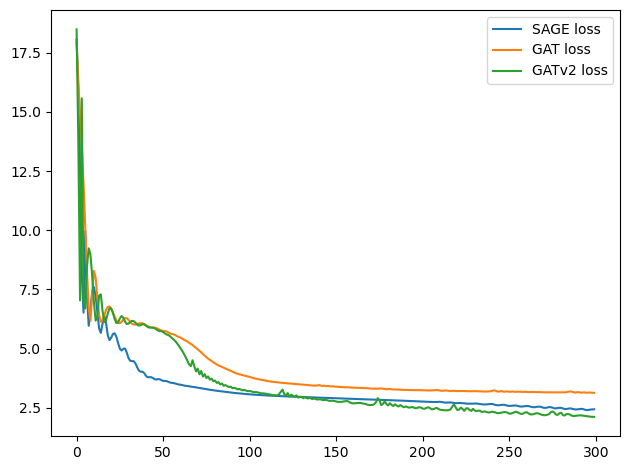

In [13]:
plt.plot((stats['loss']), label='SAGE loss')
plt.plot((MyStats['loss']), label='GAT loss')
plt.plot((MyAnotherStats['loss']), label='GATv2 loss')
plt.legend()
plt.tight_layout()
plt.show()

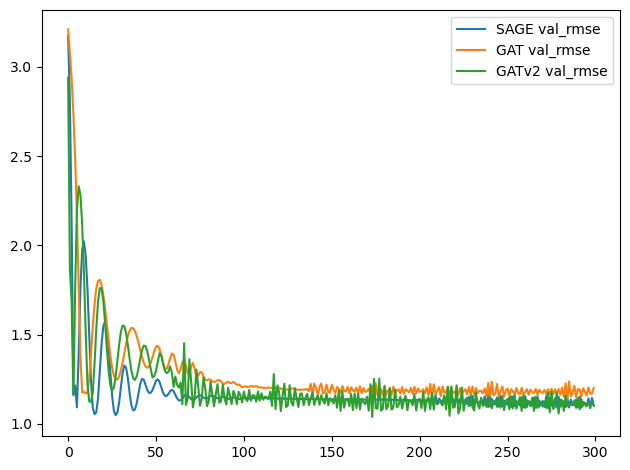

In [14]:
plt.plot((stats['val_rmse']), label='SAGE val_rmse')
plt.plot((MyStats['val_rmse']), label='GAT val_rmse')
plt.plot((MyAnotherStats['val_rmse']), label='GATv2 val_rmse')
plt.legend()
plt.tight_layout()
plt.show()

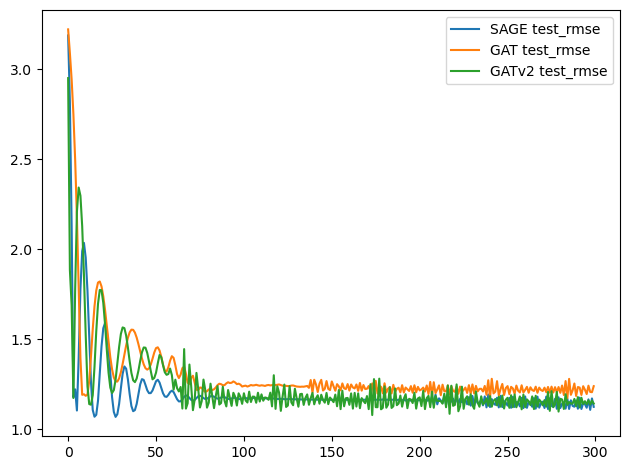

In [15]:
plt.plot((stats['test_rmse']), label='SAGE test_rmse')
plt.plot((MyStats['test_rmse']), label='GAT test_rmse')
plt.plot((MyAnotherStats['test_rmse']), label='GATv2 test_rmse')
plt.legend()
plt.tight_layout()
plt.show()